### 机器学习之数据集基本特征可视化(二)
上一篇文章简单了解了获取数据，切分训练集和测试集，对数据的简单理解。
接着对数据做进行更深一步的探索与可视化。

In [31]:
#准备工作
# 基本包的导入
import numpy as np
import os

# 画图相关
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

# 忽略警告
import warnings

# 图片存储目录
PROJECT_ROOT_DIR = '../'
CHAPTER_ID = 'end_to_end_project'
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("保存图片:", fig_id)
    
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


warnings.filterwarnings(action='ignore', module='scipy', message='internal')

# 加载数据
HOUSING_PATH = os.path.join("../datasets", "housing")
def loading_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = loading_housing_data()

In [32]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

In [33]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) 
for train_index, test_index in split.split(housing, housing["income_cat"]):
        strat_train_set = housing.loc[train_index]
        strat_test_set = housing.loc[test_index]

for set in (strat_train_set, strat_test_set): 
    set.drop(["income_cat"], axis=1, inplace=True)

以上是准备工作，涉及获取数据，分层抽样测试集。

### 进一步探索和可视化数据

由于数据量比较小，因此可以操作整个数据集。首先不影响训练集，进行copy。

In [34]:
housing = strat_train_set.copy()

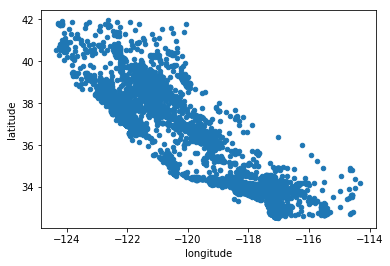

In [35]:
# 可视化地理数据，经纬度信息
housing.plot(kind='scatter', x='longitude', y='latitude')

pd.plot()函数会经常用到，kind表示画图类，x，y分别表示某个属性数据。

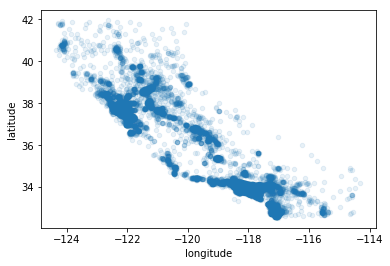

In [36]:
# 由于上图中点的大小，透明度一致，无法精确地反映出某个地区的密集程度，因此用如下方法：
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

上图要好很多，可以清楚的看到高密度区域。更进一步， 往图上加入跟多的信息。比如控制每个点的大小，让其表示特定的意义：如下：

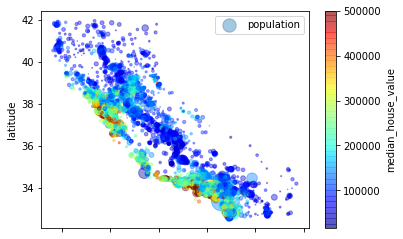

In [37]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
            s=housing["population"]/100, label="population", 
             c="median_house_value", cmap=plt.get_cmap("jet"),colorbar=True)
plt.legend()

如图有更详细的信息：s 表示特性属性决定点的半径，c表示特定的颜色。plt.legend()用于显示图例。

根据图片信息，可以推断地理位置跟房价有很大的关系。

### 数据间的相互关系

由于数据集不是很大，因此可以用全部数据计算不同属性间的线性相关系数， 使用corr()函数。

In [38]:
corr_matirx = housing.corr()

可以针对某个属性，查看其它属性与该属性之间的线性相关，1表示正相关， 0--不相关， -1 -- 负相关。


In [39]:
corr_matirx['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

该函数只能刻画属性之间的线性关系，不能描述非线性关系。另一个可视化方法如下：

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  after removing the cwd from sys.path.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1dbc47f0>,
      dtype=object)

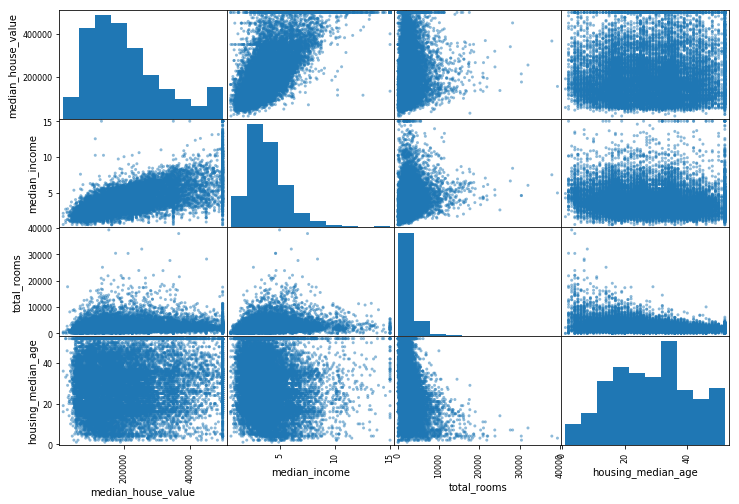

In [41]:
from pandas.tools.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms",
                  "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

从上面两种方式都得知，median income跟房价的关联性比较大。着重看一下其相关性。

[0, 16, 0, 550000]

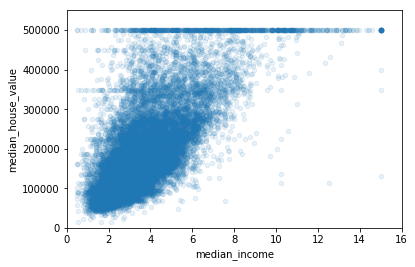

In [43]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
            alpha=0.1)
plt.axis([0, 16, 0, 550000])

axis表示做标注的范围。上图表明，两属性之间的相关性比较强，可以看到明显的上升趋势，并且点也不离散。
并且房价又明显的上限，但在某几处也有明显的水平线， 可能需要移除它们，防止其干扰训练。

### 属性组合的探索
经过上面的分析，发现了一些干扰数据，后面需要对齐进行清洗。也有部分头尾较大的数据，需要求其对数。
另外可以对特征进行组合分析。比如total rooms ， 如果不知道人口数的话，对于房价来说关联性不强。
比较想知道的是人均房间数。下面计算了平均房间数， 平均卧室数， 平均人口数。


In [46]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]


In [47]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN,4.625369,0.223852,2.094395
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN,6.008850,0.159057,2.707965
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN,4.225108,0.241291,2.025974
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND,5.232295,0.200866,4.135977
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN,4.505810,0.231341,3.047847


In [51]:
# 看一下相关性
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

如上，bedrooms_per_room 与房价之间的关系有较强的负相关性，显示每栋房子中的卧室越少， 房价越贵。


### 总结
针对数据的探索永远都可以进行，关键要从正确的角度出发，迅速得到关键点，可以得到一个较好的原型。该训练的过程汇总，可以反复回到这一步，进行特征探索。